# Tracing flow directions

Here we assume that flow directions are known. We read the flow direction raster data, including meta-data, using [rasterio](https://rasterio.readthedocs.io/en/latest/) and parse it to a pyflwdir `FlwDirRaster` object, see earlier examples for more background.

In [1]:
# import pyflwdir, some dependencies and convenience methods
import geopandas as gpd
import numpy as np
import rasterio
import pyflwdir

# local convenience methods (see utils.py script in notebooks folder)
from utils import quickplot  # data specific quick plot method

# read and parse data
with rasterio.open("rhine_d8.tif", "r") as src:
    flwdir = src.read(1)
    crs = src.crs
    flw = pyflwdir.from_array(
        flwdir,
        ftype="d8",
        transform=src.transform,
        latlon=crs.is_geographic,
        cache=True,
    )

## Flow paths

To trace flow paths downstream from a point, for instance to trace polutants from a 
point source, we can use the [path()](https://deltares.github.io/PyFlwDir/latest/_generated/pyflwdir.FlwdirRaster.path.html) method. Here 
we trace three point sources along a maximum distance of 400 km. 

In [2]:
# flow paths return the list of linear indices
xy = ([8.92, 5.55, 8.50], [50.28, 49.80, 47.3])
flowpaths, dists = flw.path(xy=xy, max_length=400e3, unit="m")
# note that all distances are nearly at the threshold
dists / 1e3

array([399.65154926, 399.27247071, 399.98337107])

In [3]:
# derive streams for visualization
streams_feat = flw.streams(min_sto=6)
gdf_streams = gpd.GeoDataFrame.from_features(streams_feat, crs=crs)
streams = (gdf_streams, dict(color="grey"))

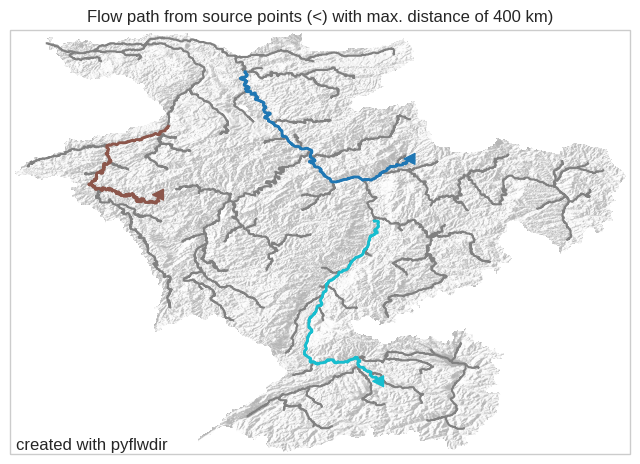

In [4]:
# which we than use to vectorize to geofeatures
feats = flw.geofeatures(flowpaths)
gdf_paths = gpd.GeoDataFrame.from_features(feats, crs=crs).reset_index()
gdf_pnts = gpd.GeoDataFrame(geometry=gpd.points_from_xy(*xy)).reset_index()
# and plot
pnt = (gdf_pnts, dict(column="index", cmap="tab10", s=60, marker="<", zorder=4))
fp = (gdf_paths, dict(column="index", cmap="tab10", linewidth=2))
title = "Flow path from source points (<) with max. distance of 400 km)"
ax = quickplot([streams, fp, pnt], title=title, filename="flw_path")

## Snap points to stream

With the [snap()](https://deltares.github.io/PyFlwDir/latest/_generated/pyflwdir.FlwdirRaster.snap.html) method we can find the nearest downstream stream for any given point and calculate
the distance to this point.

In [5]:
# find nearest stream order 8 stream
idxs1, dists = flw.snap(xy=xy, mask=flw.stream_order() >= 8, unit="m")
# convert index to coordinates and Point Geo
xy1 = flw.xy(idxs1)
gdf_pnts1 = gpd.GeoDataFrame(geometry=gpd.points_from_xy(*xy1), crs=crs).reset_index()
# print end locations
print([f"({x:.3f}, {y:.3f})" for x, y in zip(*xy1)])

['(8.562, 50.096)', '(5.579, 50.621)', '(8.221, 47.604)']


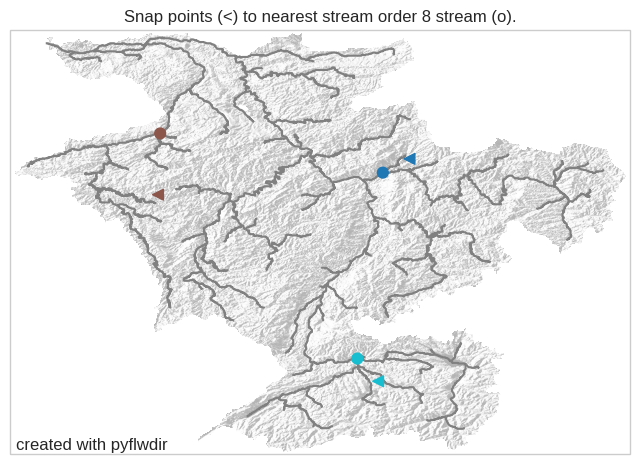

In [6]:
# plot
pnt1 = (gdf_pnts1, dict(column="index", cmap="tab10", s=60, marker="o", zorder=4))
streams = (gdf_streams, dict(color="grey"))
title = "Snap points (<) to nearest stream order 8 stream (o)."
ax = quickplot([streams, pnt1, pnt], title=title, filename="flw_snap")